# In this project I will be forecasting synthetic time series data using various methods including naive forecasting, moving average, etc.

### First import the necessary libraries

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Define some utility functions for futher reuse

In [43]:
# Define a function to plot the time series data

def plot_series(time, series,  format="-", start=0, end=None):

  # Define the scale of the canvas
  plt.figure(figsize=(10,6))

  # Check if the series contains multiple serieses. If so plot them all
  if type(series) is tuple:
    for series_no in series:
      plt.plot(time[start:end], series_no[start:end], format)

  else:
    plt.plot(time[start:end], series[start:end], format)


  # Define the label of both X and Y axis
  plt.xlabel("Time")
  plt.ylabel("Value")

  # Make a grid of the series
  plt.grid(True)
  plt.legend()

  plt.show()


In [44]:
# Define a trend generating function
def trend(time, slope=0):

  series = slope * time + 1.5
  return series

# Define a seasonal pattern generating series
def seasonal_pattern(season_time):

  data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  return data_pattern

# Define a season generating series
def seasonality(time, period, amplitude=1, phase=0):

  # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

# Define noise
def noise(time, noise_level=1, seed=None):

  # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise


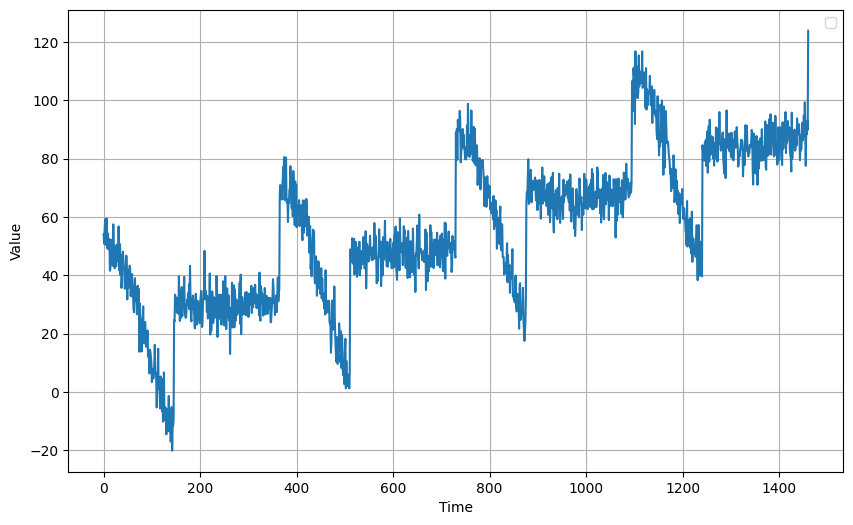

In [45]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split the dataset into training and validation set. Finally observe the result of splitting

In [46]:
split_time = 1050

time_train = time[:split_time]
series_train = series[:split_time]

time_val = time[split_time:]
series_val = series[split_time:]

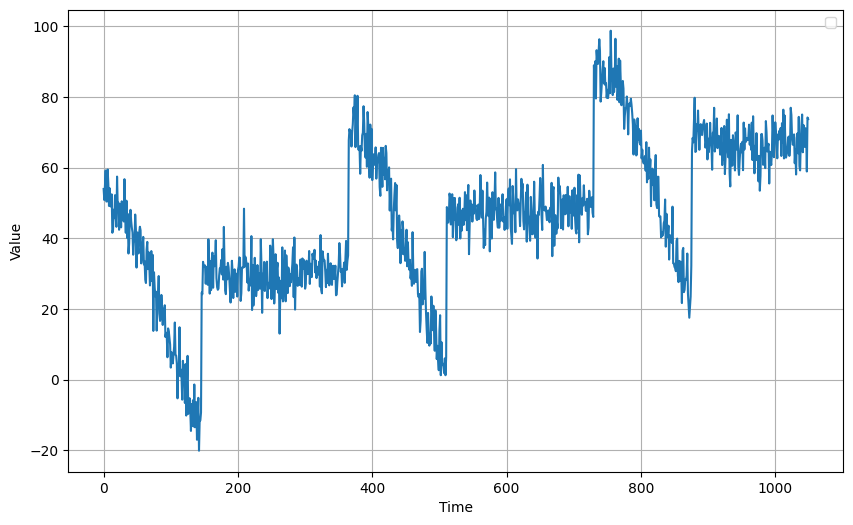

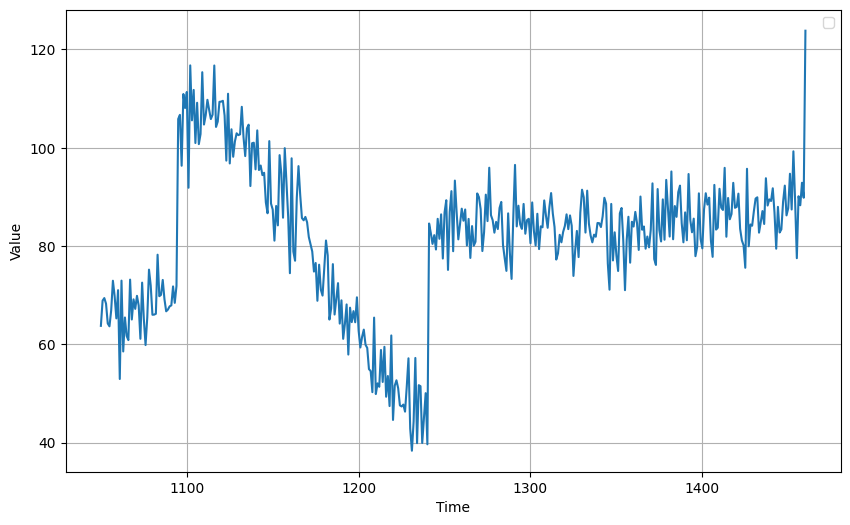

In [47]:
# Plotting of training and validation set

plot_series(time_train, series_train)
plot_series(time_val, series_val)

In [48]:
print(f"Length of the train series: {len(series_train)}")
print(f"Length of the validation series: {len(series_val)}")

Length of the train series: 1050
Length of the validation series: 411


### Predict values based on Naive Forecast meaning the next value will be the same as the previous time step.

In [49]:
# Generate the naive forecast
naive_forecast = series[split_time-1:-1]

time_step = 50

print(f"Ground truth value at time step {time_step}: {series_val[time_step]}")
print(f"Predicted value at time step {time_step}: {naive_forecast[time_step]}")

Ground truth value at time step 50: 111.34197998046875
Predicted value at time step 50: 108.08765411376953


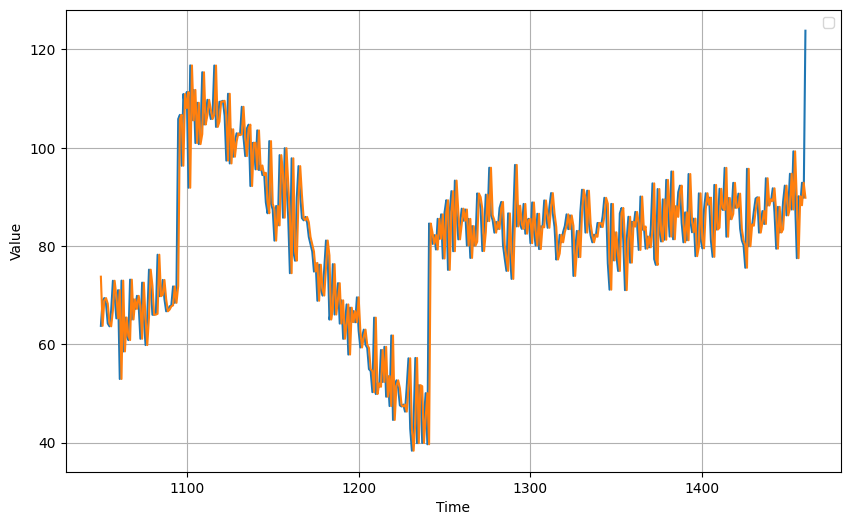

In [50]:
# Plot the ground truth and the predicted values
plot_series(time_val, (series_val, naive_forecast))

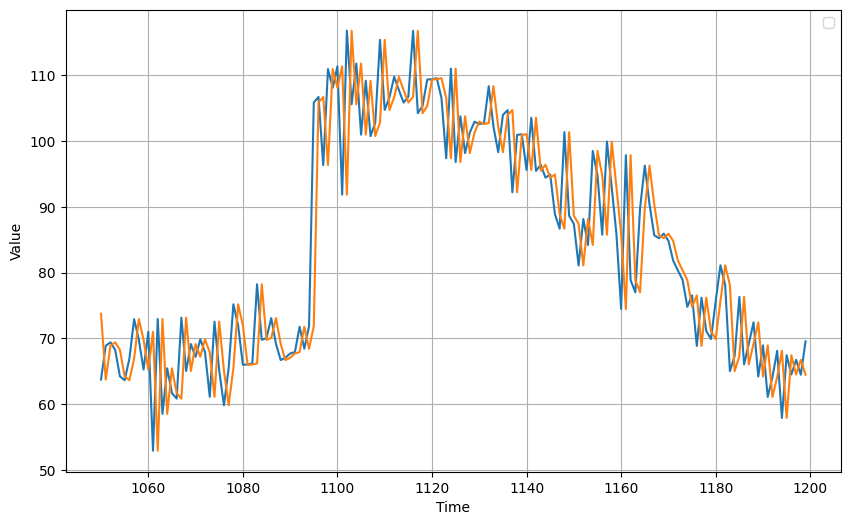

In [51]:
# Zooming in
plot_series(time_val, (series_val, naive_forecast), start=0, end=150)

### Error metrics computation

In [52]:
print(tf.keras.metrics.mean_squared_error(series_val, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(series_val, naive_forecast).numpy())

63.778618
5.9975343


### Moving-average forecast

In [53]:
def moving_average(series, window_size):

  forecast = []

  for time in range(len(series) - window_size):
    forecast.append(series[time:time+window_size].mean())

  forecast = np.array(forecast)

  return forecast


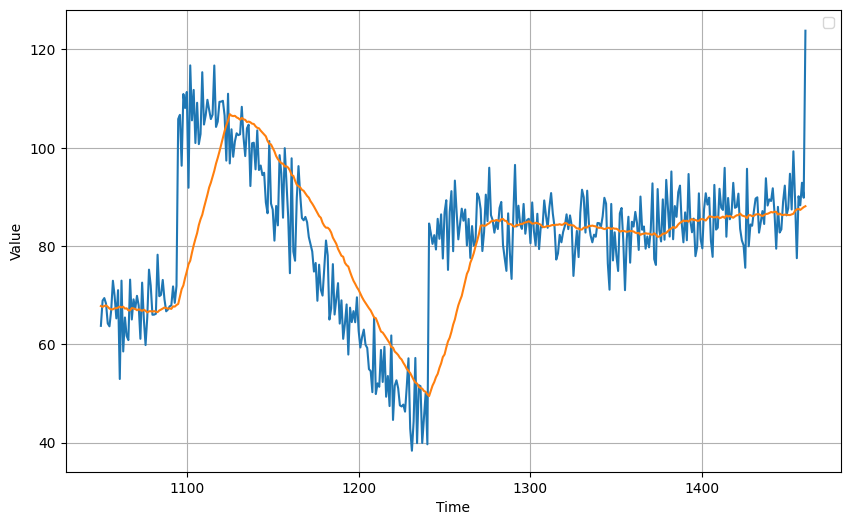

In [54]:
# Calculate the moving average series
moving_avg = moving_average(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_val, (series_val, moving_avg))

In [55]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(series_val, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(series_val, moving_avg).numpy())

116.551056
7.4984775


### Differencing method

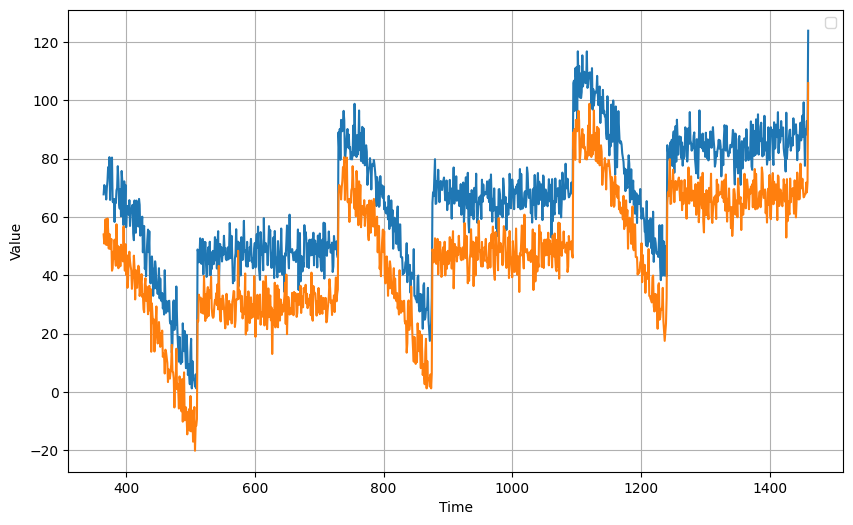

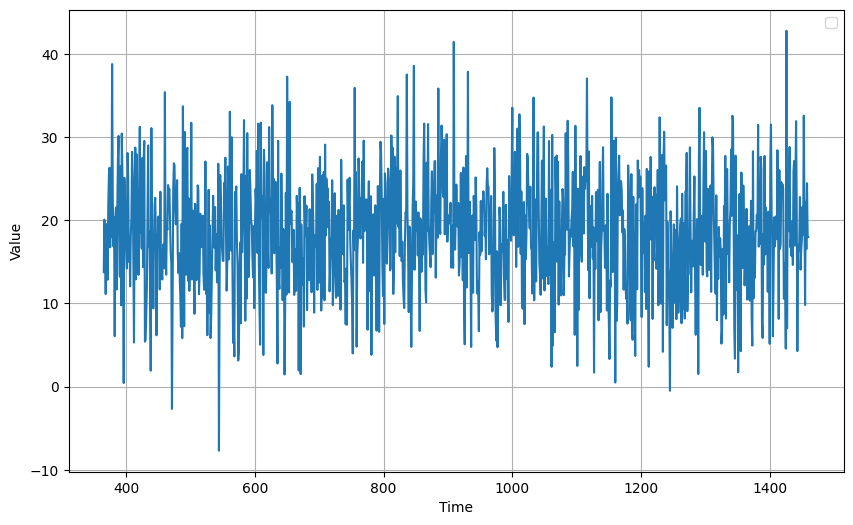

In [56]:
# Series from the beginning of the second seasonality until the end
series1 = series[365:]

# Series from the beginning upto the beginning of the last seasonality
series2 = series[:-365]

# Subtract the values at t-365 from original series
diff_series = (series1 - series2)

# Truncate the first 365 time steps
time = time[365:]

# Plot the two different series
plot_series(time, (series1, series2))

# Plot the resulting series
plot_series(time, diff_series)

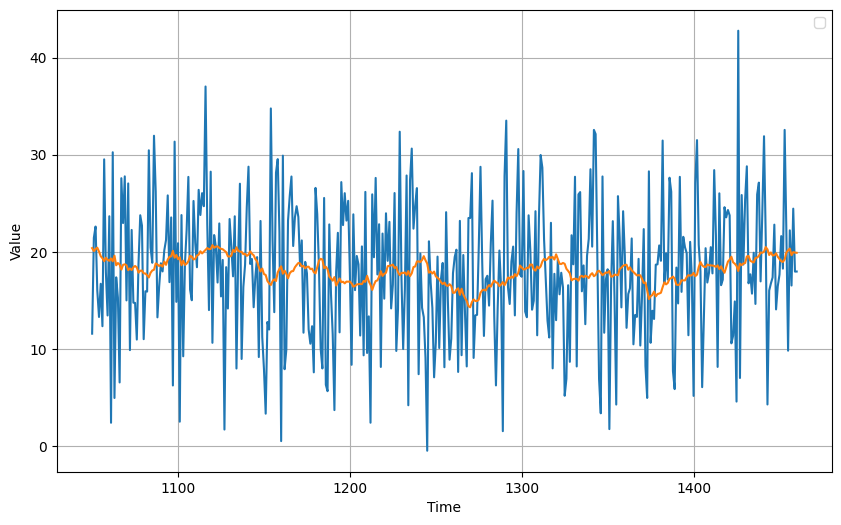

In [57]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_val, (diff_series, diff_moving_avg))

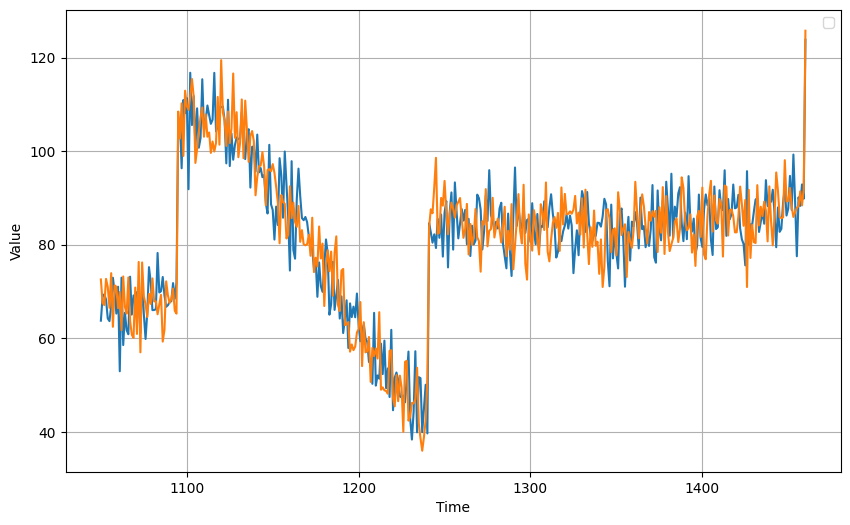

In [58]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_val, (series_val, diff_moving_avg_plus_past))

In [61]:
print(tf.keras.metrics.mean_squared_error(series_val, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(series_val, diff_moving_avg_plus_past).numpy())

53.51765
5.878443
